In [ ]:
import pandas as pd
import numpy as np
import re
import string
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import keras

In [2]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    #MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    #MAX_LEN = 75
    EMBEDDING = 20

In [3]:
df = pd.read_excel (r'punjabi_cleaned_data.xlsx', sheet_name='Sheet1')
df.head(5)

,sent_index,word,tag
0,0,ਸੰਯੁਕਤ,B-LOC
1,0,ਰਾਸ਼ਟਰ,O
2,0,ਦੀ,I-LOC
3,0,ਸਥਾਪਨਾ,O
4,0,ਅਕਤੂਬਰ,O


In [4]:
data = df.copy()

In [5]:
words = list(set(data["word"].values))
#words.append("ENDPAD")
n_words = len(words); 
n_words

7060

In [6]:
tags = list(set(data["tag"].values))
n_tags = len(tags); n_tags

7

In [7]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sent_index").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
#         try:
        s = self.grouped[int("{}".format(self.n_sent))]
        self.n_sent += 1
        return s
#         except:
#             return None

In [8]:
#data[data['sent_index']==1]

In [9]:
getter = SentenceGetter(data)

In [10]:
print(getter.get_next())

[('ਸੰਯੁਕਤ', 'B-LOC'), ('ਰਾਸ਼ਟਰ', 'O'), ('ਦੀ', 'I-LOC'), ('ਸਥਾਪਨਾ', 'O'), ('ਅਕਤੂਬਰ', 'O'), ('ਨੂੰ', 'O'), ('ਹੋਈ', 'O'), ('ਸੀ', 'I-PER'), ('ਤਾਂਕਿ', 'O'), ('ਅੰਤਰਰਾਸ਼ਟਰੀ', 'O'), ('ਕਾਨੂੰਨ', 'O'), ('ਅੰਤਰਰਾਸ਼ਟਰੀ', 'O'), ('ਸੁਰੱਖਿਆ', 'O'), ('ਆਰਥਕ', 'O'), ('ਵਿਕਾਸ', 'I-ORG'), ('ਅਤੇ', 'I-ORG'), ('ਸਮਾਜਕ', 'O'), ('ਨਿਰਪਖਤਾ', 'O'), ('ਵਿੱਚ', 'O'), ('ਸਹਿਯੋਗ', 'O'), ('ਸਰਲ', 'O'), ('ਹੋ', 'O'), ('ਪਾਏ', 'O'), ('।', 'O')]


In [11]:
sentences = getter.sentences

In [12]:
MAX_LEN  = max([len(s) for s in sentences])
print ('Maximum sequence length:', MAX_LEN)

Maximum sequence length: 573


In [13]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [14]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=MAX_LEN , sequences=X, padding="post", value=n_words-1)
X

array([[6824,  940, 6782, ..., 7059, 7059, 7059],
       [6824, 6732,  185, ..., 7059, 7059, 7059],
       [2533, 2904, 1484, ..., 7059, 7059, 7059],
       ...,
       [3582, 4748, 6348, ..., 7059, 7059, 7059],
       [3582, 4748, 6348, ..., 7059, 7059, 7059],
       [4845, 4748, 4389, ..., 7059, 7059, 7059]])

In [15]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=MAX_LEN , sequences=y, padding="post", value=tag2idx["O"])


In [16]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

# Setup the CRF-LSTM

In [17]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
import keras as k

In [18]:

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



C:\Users\sagun\anaconda3\envs\Capstone1\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
C:\Users\sagun\anaconda3\envs\Capstone1\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 573)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 573, 20)           141240    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 573, 100)          28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 573, 50)           5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 573, 7)            420       
Total params: 175,110
Trainable params: 175,110
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.1, verbose=2)


Train on 2419 samples, validate on 269 samples
Epoch 1/5
 - 70s - loss: 0.1667 - crf_viterbi_accuracy: 0.9480 - val_loss: 0.0373 - val_crf_viterbi_accuracy: 0.9887
Epoch 2/5
 - 74s - loss: 0.0332 - crf_viterbi_accuracy: 0.9898 - val_loss: 0.0303 - val_crf_viterbi_accuracy: 0.9908
Epoch 3/5
 - 80s - loss: 0.0236 - crf_viterbi_accuracy: 0.9923 - val_loss: 0.0201 - val_crf_viterbi_accuracy: 0.9926
Epoch 4/5
 - 74s - loss: 0.0155 - crf_viterbi_accuracy: 0.9943 - val_loss: 0.0149 - val_crf_viterbi_accuracy: 0.9947
Epoch 5/5
 - 77s - loss: 0.0107 - crf_viterbi_accuracy: 0.9966 - val_loss: 0.0108 - val_crf_viterbi_accuracy: 0.9967


In [24]:
model.save('bi_lstm_crf_punjabi.h5')

In [26]:
i = 3
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_te[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))

Word           (True ): Pred
ਗਤੀਵਿਧੀਆਂ     : O
ਬੁੱਢਾ         : O
ਬਿਸ਼ਪ         : I-ORG
ਸਧਨਾ          : O
ਸੈਂਟ          : I-LOC
ਕੋਰਨੇਲਾ       : O
ਸੈਟੇਲਾਈਟ      : O
ਪੂਰਵ          : B-LOC
ਨਿਵਾਸ         : B-LOC
ਕਸਬੇ          : I-LOC
ਕੂਰਟਨੇ        : O
ਸਾਧਨ          : O
ਪਰਕਾਸ਼        : I-ORG
ਗੈਰ           : I-ORG
ਹਲ            : O
ਯੋਗੀ          : O
ਮਾਲਕੀ         : O
ਮਹੱਤਵਪੂਰਨ     : I-ORG
ਸੈਣ           : O
ਕਰੋੜ          : O
ਮਹੱਤਵਪੂਰਣ     : O
ਸਲਾਈ          : O
ਸਧਨਾ          : O
ਫ੍ਰਾਂਸ        : O
ਗਤੀਵਿਧੀਆਂ     : O
ਮਹੱਤਵਪੂਰਨ     : I-ORG
ਐਸੋਸੀਏਟਸ      : I-PER
ਮਹੱਤਵਪੂਰਣ     : O
ਸੈਣ           : O
ਯੋਗੀ          : O
ਬਿਆਨ          : O
ਕਰੋੜ          : O
ਹੇਰਤਾ         : I-ORG
ਵੈਦ           : O
ਕੋਰਨੇਲਾ       : O
ਜੁੱਲ          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹          : O
삼성그룹     

In [27]:

from tqdm import tqdm


In [28]:
pred = []
for i in tqdm(range(len(y_te))):
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    pred.append(p)

100%|██████████| 299/299 [00:36<00:00,  8.28it/s]


In [29]:
pred_temp = [x[0] for x in pred]

y_temp = []

for i in range(len(y_te)):
    y_temp.append(np.array([np.where(y_te[i][j]==1)[0][0] for j in range(len(y_te[i]))]))

In [30]:
actual = y_temp[0]
for i in range(1, len(y_temp)):
    actual = np.concatenate((actual, y_temp[i]), axis=None)

In [31]:
predicted = pred_temp[0]
for i in range(1, len(pred_temp)):
    predicted = np.concatenate((predicted, pred_temp[i]), axis=None)

In [32]:
import scikitplot as skplt
from sklearn.metrics import classification_report

              precision    recall  f1-score   support

       I-LOC       0.70      0.88      0.78       309
       I-ORG       0.98      0.87      0.92       730
       B-LOC       0.72      0.61      0.66       251
       B-ORG       0.59      0.14      0.23        90
       I-PER       0.58      0.93      0.71       335
           O       1.00      1.00      1.00    169494
       B-PER       0.59      0.17      0.26       118

    accuracy                           1.00    171327
   macro avg       0.74      0.66      0.65    171327
weighted avg       1.00      1.00      1.00    171327



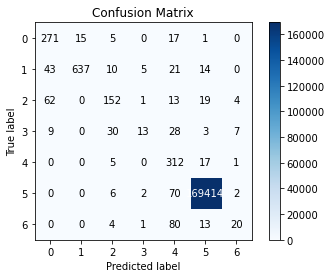

In [33]:
skplt.metrics.plot_confusion_matrix(actual, predicted)
print(classification_report(actual, predicted, target_names=tags))